## Modules & Functions

In [0]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pylab as pl,pandas as pd
import sys,h5py,urllib,zipfile
import tensorflow as tf
import tensorflow_hub as th
from sklearn.model_selection import train_test_split
fpath='https://olgabelitskaya.github.io/'

In [0]:
def prepro(x_train,y_train,x_test,y_test,n_class):
    n=int(len(x_test)/2)
    x_train=x_train.astype('float32')/255
    x_test=x_test.astype('float32')/255
    y_train=y_train.astype('int32')
    y_test=y_test.astype('int32')    
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    cy_train=tf.keras.utils.to_categorical(y_train,n_class) 
    cy_valid=tf.keras.utils.to_categorical(y_valid,n_class)
    cy_test=tf.keras.utils.to_categorical(y_test,n_class)
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [cy_train.shape,cy_valid.shape,cy_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels','encoded labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]
def display_10img(X,y,s):
    fig,ax=pl.subplots(figsize=(10,3),nrows=2,ncols=5,
                       sharex=True,sharey=True)
    ax=ax.flatten()
    for i in range(10):
        ax[i].imshow(X[i].reshape(s,s,3),cmap=pl.cm.Pastel1)
        ax[i].set_title(y[i])
    ax[0].set_xticks([]); ax[0].set_yticks([])
    pl.tight_layout()
def display_resize(x_train,x_valid,x_test,
                   y_valid,cy_valid,pixels):
    x_train=tf.image.resize(x_train,[pixels,pixels])
    x_valid=tf.image.resize(x_valid,[pixels,pixels])
    x_test=tf.image.resize(x_test,[pixels,pixels])
    img=x_valid[1]
    lbl='one example of resized images \nlabel: '+\
     str(y_valid[1][0])+'=>'+str(cy_valid[1])+\
     '\nshape: '+str(img.shape)
    pl.imshow(img); pl.title(lbl)
    return [x_train,x_valid,x_test]
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

## Data

170500096/170498071 [==============================] - 4s 0us/step


,train,valid,test
images,"(50000, 32, 32, 3)","(5000, 32, 32, 3)","(5000, 32, 32, 3)"
labels,"(50000, 1)","(5000, 1)","(5000, 1)"
encoded labels,"(50000, 10)","(5000, 10)","(5000, 10)"


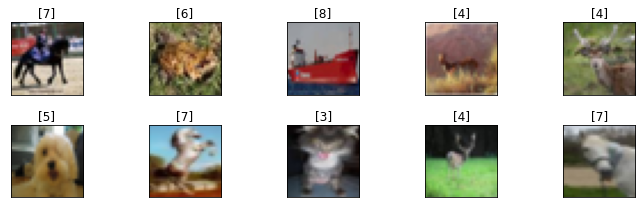

In [4]:
(x_train1,y_train1),(x_test1,y_test1)=\
tf.keras.datasets.cifar10.load_data()
[[x_train1,x_valid1,x_test1],
 [y_train1,y_valid1,y_test1],
 [cy_train1,cy_valid1,cy_test1]]=\
prepro(x_train1,y_train1,x_test1,y_test1,10)
display_10img(x_test1,y_test1,32)

['backgrounds', 'images', 'labels']


,train,valid,test
images,"(11352, 32, 32, 3)","(1419, 32, 32, 3)","(1419, 32, 32, 3)"
labels,"(11352, 1)","(1419, 1)","(1419, 1)"
encoded labels,"(11352, 33)","(1419, 33)","(1419, 33)"


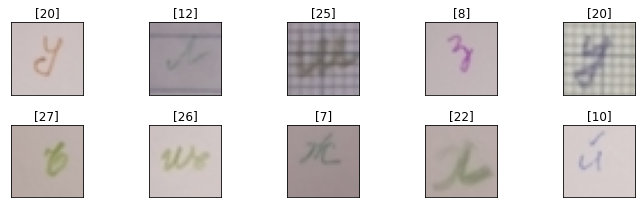

In [5]:
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
images=np.array(f[keys[1]])
labels=np.array(f[keys[2]]).reshape(-1,1)-1
x_train2,x_test2,y_train2,y_test2=\
train_test_split(images,labels,test_size=.2,random_state=1)
del images,labels
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2],
 [cy_train2,cy_valid2,cy_test2]]=\
prepro(x_train2,y_train2,x_test2,y_test2,33)
display_10img(x_test2,y_test2,32)

## MLP Building & Training

In [0]:
def cat_accuracy(predictions,labels):
    return (100.0*np.sum(np.argmax(predictions,1)==\
           np.argmax(labels,1))/predictions.shape[0])
def mlp(x,weights,biases):
    layer1=tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer2=tf.add(tf.matmul(layer1,weights['W2']),biases['b2'])
    return tf.matmul(layer2,weights['out'])+biases['out']

In [0]:
def nn_train(x_train,cy_train,x_test,cy_test,
             lr,epochs,hidden1,hidden2,batch_size,
             display_step,n_inputs,n_classes):
    graph=tf.Graph()
    with graph.as_default():
        weights={'W1':tf.Variable(\
        tf.compat.v1.random_normal([n_inputs,hidden1])),
        'W2':tf.Variable(\
        tf.compat.v1.random_normal([hidden1,hidden2])),
        'out':tf.Variable(\
        tf.compat.v1.random_normal([hidden2,n_classes]))}
        biases={'b1':tf.Variable(\
        tf.compat.v1.random_normal([hidden1])),
        'b2':tf.Variable(\
        tf.compat.v1.random_normal([hidden2])),
        'out':tf.Variable(\
        tf.compat.v1.random_normal([n_classes]))}
        X=tf.compat.v1.placeholder("float32",[None,n_inputs])
        y=tf.compat.v1.placeholder("int32",[None,n_classes])
        vX=tf.constant(x_test.reshape(-1,n_inputs))
        logits=mlp(X,weights,biases)
        vlogits=mlp(vX,weights,biases)
        loss=tf.reduce_mean(\
        tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
        train_opt=optimizer.minimize(loss)
        train_predictions=tf.nn.softmax(logits)
        test_predictions=tf.nn.softmax(vlogits)
    with tf.compat.v1.Session(graph=graph) as sess:
        tf.compat.v1.global_variables_initializer().run()
        for epoch in range(epochs):
            avg_loss=0.; avg_acc=0.
            total_batch=int(x_train.shape[0]/batch_size)
            for i in range(total_batch):
                offset=(i*batch_size)%(x_train.shape[0]-batch_size)
                batch_X=x_train.reshape(-1,32*32*3)[offset:(offset+batch_size)]
                batch_y=cy_train[offset:(offset+batch_size)]
                _,l,batch_py=\
                sess.run([train_opt,loss,train_predictions],
                         feed_dict={X:batch_X,y:batch_y})
                avg_loss+=l/total_batch
                avg_acc+=cat_accuracy(batch_py,batch_y)/total_batch
            if epoch%display_step==0:
                print("Epoch: %04d"%(epoch+1),
                      "loss={:.9f}".format(avg_loss),
                      "accuracy={:.3f}".format(avg_acc))
        print("Test accuracy: %.3f%%"%\
        cat_accuracy(test_predictions.eval(),cy_test))

In [49]:
lr=.001; epochs=15
hidden1=512; hidden2=256
batch_size=128; display_step=1 
n_inputs=32*32*3; n_classes=10
tf.compat.v1.reset_default_graph()
nn_train(x_train1,cy_train1,x_test1,cy_test1,
         lr,epochs,hidden1,hidden2,batch_size,
         display_step,n_inputs,n_classes)

Epoch: 0001 loss=2793.368313364 accuracy=20.871
Epoch: 0002 loss=1645.819675230 accuracy=25.044
Epoch: 0003 loss=1289.500822566 accuracy=26.066
Epoch: 0004 loss=1079.532596216 accuracy=27.019
Epoch: 0005 loss=952.461595115 accuracy=27.328
Epoch: 0006 loss=843.149150516 accuracy=27.877
Epoch: 0007 loss=748.009928542 accuracy=27.989
Epoch: 0008 loss=694.604594069 accuracy=28.251
Epoch: 0009 loss=632.308267212 accuracy=28.448
Epoch: 0010 loss=575.743856107 accuracy=28.758
Epoch: 0011 loss=527.516967617 accuracy=28.952
Epoch: 0012 loss=518.435194671 accuracy=28.756
Epoch: 0013 loss=461.169353622 accuracy=29.223
Epoch: 0014 loss=439.526182674 accuracy=29.046
Epoch: 0015 loss=420.630396212 accuracy=29.032
Test accuracy: 26.680%


In [47]:
lr=.001; epochs=100; hidden1=512; hidden2=256
batch_size=128; display_step=5; 
n_inputs=32*32*3; n_classes=33
tf.compat.v1.reset_default_graph()
nn_train(x_train2,cy_train2,x_test2,cy_test2,
         lr,epochs,hidden1,hidden2,batch_size,
         display_step,n_inputs,n_classes)

Epoch: 0001 loss=4421.164706143 accuracy=3.640
Epoch: 0006 loss=1616.868846547 accuracy=7.866
Epoch: 0011 loss=1361.687946666 accuracy=12.305
Epoch: 0016 loss=1009.071388938 accuracy=17.383
Epoch: 0021 loss=977.788953608 accuracy=19.176
Epoch: 0026 loss=838.789529974 accuracy=21.591
Epoch: 0031 loss=745.890667308 accuracy=24.148
Epoch: 0036 loss=670.092237299 accuracy=25.728
Epoch: 0041 loss=679.392908270 accuracy=27.086
Epoch: 0046 loss=585.406939073 accuracy=28.489
Epoch: 0051 loss=593.898197521 accuracy=29.350
Epoch: 0056 loss=519.533272830 accuracy=29.856
Epoch: 0061 loss=517.507678292 accuracy=30.487
Epoch: 0066 loss=463.885197726 accuracy=32.147
Epoch: 0071 loss=466.931737380 accuracy=32.022
Epoch: 0076 loss=464.094485890 accuracy=32.120
Epoch: 0081 loss=405.632944974 accuracy=32.795
Epoch: 0086 loss=408.291657881 accuracy=33.061
Epoch: 0091 loss=364.934445641 accuracy=35.281
Epoch: 0096 loss=408.052924416 accuracy=32.289
Test accuracy: 29.669%


## CNN Building & Training

In [0]:
lr=.001; epochs=200; 
batch_size=128; display_step=5 
img_size=32; n_classes=10
save_model_path='./img_class'

In [0]:
def cnn(x,n_classes,conv1,conv2,dense1):
    W1=tf.Variable(tf.compat.v1\
         .truncated_normal([2,2,x.shape[3],conv1],stddev=.04))
    b1=tf.Variable(tf.compat.v1\
         .constant(.04,shape=[conv1]))
    x=tf.nn.conv2d(x,W1,strides=[1,5,5,1],padding='SAME')
    x=tf.nn.relu(x+b1)
    x=tf.nn.max_pool(x,ksize=[1,2,2,1], 
                     strides=[1,2,2,1],padding='SAME')
    x=tf.nn.dropout(x,.2)
    W2=tf.Variable(tf.compat.v1\
         .truncated_normal([2,2,x.shape[3],conv2],stddev=.04))
    b2=tf.Variable(tf.compat.v1\
         .constant(.04,shape=[conv2]))
    x=tf.nn.conv2d(x,W2,strides=[1,2,2,1],padding='SAME')
    x=tf.nn.relu(x+b2)
    x=tf.nn.max_pool(x,ksize=[1,2,2,1], 
                     strides=[1,2,2,1],padding='SAME')
    x=tf.nn.dropout(x,.2)
    x=tf.reshape(x,[-1,x.shape[1]*x.shape[2]*x.shape[3]])
    W3=tf.Variable(tf.compat.v1.\
    truncated_normal([x.shape[1],dense1],stddev=.04))
    b3=tf.Variable(tf.compat.v1.truncated_normal([dense1],stddev=.04))
    x=tf.nn.relu(tf.add(tf.matmul(x,W3),b3)) 
    W=tf.Variable(tf.compat.v1.\
    truncated_normal([x.shape[1],n_classes],stddev=.04))
    b=tf.Variable(tf.compat.v1.truncated_normal([n_classes],stddev=.04))
    x=tf.add(tf.matmul(x,W),b)
    return x

In [0]:
tf.compat.v1.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    X=tf.compat.v1.\
    placeholder("float32",[None,img_size,img_size,3],name='x')
    y=tf.compat.v1.placeholder("int32",[None,n_classes],name='y')
    logits=cnn(X,n_classes,32,196,1024)
    logits=tf.compat.v1.identity(logits,name='logits')
    loss=tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
    train_opt=optimizer.minimize(loss)
    train_predictions=tf.nn.softmax(logits)
    correct_predictions=tf.equal(tf.argmax(train_predictions,1),
                                 tf.argmax(y,1))
    accuracy=tf.reduce_mean(tf.cast(correct_predictions,tf.float32),
                            name='accuracy')

In [0]:
with tf.compat.v1.Session(graph=graph) as sess:
    tf.compat.v1.global_variables_initializer().run()
    for epoch in range(epochs):
        avg_loss=0.; avg_acc=0.
        total_batch=int(x_train1.shape[0]/batch_size)
        for i in range(total_batch):
            offset=(i*batch_size)%(x_train1.shape[0]-batch_size)
            batch_X=x_train1[offset:(offset+batch_size)]
            batch_y=cy_train1[offset:(offset+batch_size)]
            _,l,_,_,acc=sess.run([train_opt,loss,train_predictions,
                                  correct_predictions,accuracy],
                                  feed_dict={X:batch_X,y:batch_y})
            avg_loss+=l/total_batch
            avg_acc+=acc/total_batch
        if epoch%display_step==0:
            print("Epoch: %04d"%(epoch+1),
                  "loss={:.9f}".format(avg_loss),
                  "accuracy={:.3f}".format(avg_acc))
    saver=tf.compat.v1.train.Saver()
    save_path=saver.save(sess,save_model_path)

Epoch: 0001 loss=2.005353038 accuracy=0.257
Epoch: 0006 loss=1.512975966 accuracy=0.456
Epoch: 0011 loss=1.411820935 accuracy=0.494
Epoch: 0016 loss=1.349958150 accuracy=0.516
Epoch: 0021 loss=1.297602625 accuracy=0.535
Epoch: 0026 loss=1.265571305 accuracy=0.546
Epoch: 0031 loss=1.233423490 accuracy=0.561
Epoch: 0036 loss=1.204294029 accuracy=0.568
Epoch: 0041 loss=1.174655667 accuracy=0.578
Epoch: 0046 loss=1.149312795 accuracy=0.588
Epoch: 0051 loss=1.133274946 accuracy=0.593
Epoch: 0056 loss=1.103784682 accuracy=0.604
Epoch: 0061 loss=1.087608676 accuracy=0.611
Epoch: 0066 loss=1.072764122 accuracy=0.616
Epoch: 0071 loss=1.056838707 accuracy=0.621
Epoch: 0076 loss=1.036333260 accuracy=0.630
Epoch: 0081 loss=1.019622315 accuracy=0.632
Epoch: 0086 loss=1.007306124 accuracy=0.638
Epoch: 0091 loss=0.992398893 accuracy=0.643
Epoch: 0096 loss=0.983782204 accuracy=0.647
Epoch: 0101 loss=0.976140585 accuracy=0.649
Epoch: 0106 loss=0.970153968 accuracy=0.651
Epoch: 0111 loss=0.954078805 acc

In [0]:
loaded_graph=tf.Graph()
with tf.compat.v1.Session(graph=loaded_graph) as sess:
    loader=tf.compat.v1.train.import_meta_graph(save_model_path+'.meta')
    loader.restore(sess,save_model_path)
    loaded_X=loaded_graph.get_tensor_by_name('x:0')
    loaded_y=loaded_graph.get_tensor_by_name('y:0')
    loaded_logits=loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc=loaded_graph.get_tensor_by_name('accuracy:0')
    loss=tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=loaded_logits,
                                            labels=loaded_y))
    avg_loss=0.; avg_acc=0.
    total_batch=int(x_valid1.shape[0]/batch_size)
    for i in range(total_batch):
        offset=(i*batch_size)%(x_valid1.shape[0]-batch_size)
        batch_X=x_valid1[offset:(offset+batch_size)]
        batch_y=cy_valid1[offset:(offset+batch_size)]
        l,acc=sess.run([loss,loaded_acc],
                     feed_dict={loaded_X:batch_X,
                                loaded_y:batch_y})
        avg_loss+=l/total_batch
        avg_acc+=acc/total_batch
    print("test loss={:.9f}".format(avg_loss),
          "test accuracy={:.3f}".format(avg_acc))

INFO:tensorflow:Restoring parameters from ./img_class
test loss=1.716839295 test accuracy=0.492


## Comparing with Keras Applications

In [0]:
def premodel(pix,den,mh,lbl):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='categorical_crossentropy')
    display(model.summary())
    return model

In [0]:
[handle_base,pixels]=["mobilenet_v2_050_96",96]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)
fw='weights.best.hdf5'

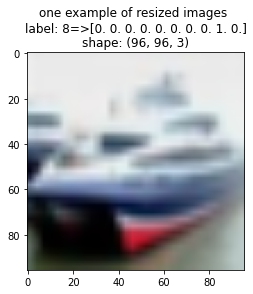

In [52]:
[x_train1,x_valid1,x_test1]=\
display_resize(x_train1,x_valid1,x_test1,
               y_valid1,cy_valid1,pixels)

In [53]:
model=premodel(pixels,512,mhandle,10)
history=model.fit(x=x_train1,y=cy_train1,batch_size=64,
                  epochs=10,callbacks=cb(fw),
                  validation_data=(x_valid1,cy_valid1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              706224    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 1,367,226
Trainable params: 1,348,682
Non-trainable params: 18,544
_________________________________________________________________


None

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.8046
Epoch 00001: val_loss improved from inf to 0.53988, saving model to weights.best.hdf5
782/782 [==============================] - 38s 48ms/step - loss: 0.6456 - accuracy: 0.8046 - val_loss: 0.5399 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 2/10
782/782 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.8642
Epoch 00002: val_loss improved from 0.53988 to 0.49200, saving model to weights.best.hdf5
782/782 [==============================] - 36s 47ms/step - loss: 0.4635 - accuracy: 0.8642 - val_loss: 0.4920 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 3/10
781/782 [============================>.] - ETA: 0s - loss: 0.3982 - accuracy: 0.8853
Epoch 00003: val_loss did not improve from 0.49200
782/782 [==============================] - 36s 46ms/step - loss: 0.3981 - accuracy: 0.8854 - val_loss: 0.4989 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 4/10
781/782 [===========================

In [54]:
model.load_weights(fw)
model.evaluate(x_test1,cy_test1)

157/157 [==============================] - 1s 7ms/step - loss: 0.4444 - accuracy: 0.8844


[0.44437241554260254, 0.8844000101089478]

In [0]:
del x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1,\
cy_train1,cy_valid1,cy_test1

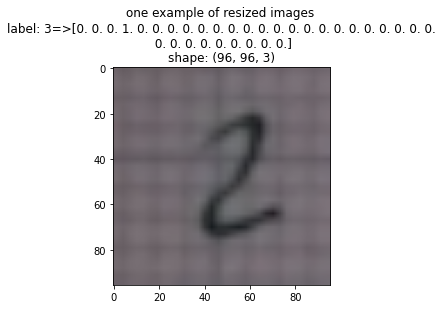

In [56]:
[x_train2,x_valid2,x_test2]=\
display_resize(x_train2,x_valid2,x_test2,
               y_valid2,cy_valid2,pixels)

In [57]:
model=premodel(pixels,512,mhandle,33)
history=model.fit(x=x_train2,y=cy_train2,batch_size=64,
                  epochs=100,callbacks=cb(fw),
                  validation_data=(x_valid2,cy_valid2))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              706224    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 33)                16929     
Total params: 1,379,025
Trainable params: 1,360,481
Non-trainable params: 18,544
_________________________________________________________________


None

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 1.4310 - accuracy: 0.6058
Epoch 00001: val_loss improved from inf to 2.11598, saving model to weights.best.hdf5
178/178 [==============================] - 9s 53ms/step - loss: 1.4310 - accuracy: 0.6058 - val_loss: 2.1160 - val_accuracy: 0.5335 - lr: 0.0010
Epoch 2/100
177/178 [============================>.] - ETA: 0s - loss: 0.4461 - accuracy: 0.8784
Epoch 00002: val_loss improved from 2.11598 to 0.71119, saving model to weights.best.hdf5
178/178 [==============================] - 8s 47ms/step - loss: 0.4458 - accuracy: 0.8785 - val_loss: 0.7112 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 3/100
177/178 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.9243
Epoch 00003: val_loss improved from 0.71119 to 0.53345, saving model to weights.best.hdf5
178/178 [==============================] - 8s 48ms/step - loss: 0.3003 - accuracy: 0.9243 - val_loss: 0.5335 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 4/

In [58]:
model.load_weights(fw)
model.evaluate(x_test2,cy_test2)

45/45 [==============================] - 0s 7ms/step - loss: 0.1497 - accuracy: 0.9767


[0.14971362054347992, 0.9767441749572754]